In [51]:
#import packages
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as pn
import statistics as st
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
pn.options.figure_size = (6,4)

def sort_factors(X_norm_log: np.ndarray, cell_score_matrix: np.ndarray, gene_loading_matrix: np.ndarray, plot_path : str, method : str = "explained_variance"):

    n_cells, _ = cell_score_matrix.shape

    n_factors, n_genes = gene_loading_matrix.shape

    # defined as variance of each selected gene divided by total variance
    if method == "explained_variance":

        # first, select top genes for each factor
        top_genes = select_top_genes(gene_loading_matrix)

        # calculate variance of each gene in cell x gene matrix
        gene_variance = [X_norm_log[:,x].var() for x in range(n_genes)]
        total_variance = sum(gene_variance)

        # divide sum of genes' variance by total to get explained_variance for each factor
        explained_variance = []

        for curr_factor in range(n_factors):
            explained_variance.append( sum([gene_variance[curr_gene] for curr_gene in top_genes[curr_factor]]) / total_variance)

        # if a plot path is provided, plot the factors' explained variance
        if plot_path:
            plot = (pn.ggplot()
                    + pn.aes(x = list(range(n_factors)), y = explained_variance)
                    + pn.xlab("Factor")
                    + pn.ylab("Explained Variance")
                    + pn.geom_point()
                    + pn.theme_bw())
            
            plot.save(f"{plot_path}/factors_explained_variance.pdf", dpi = 250, verbose = False)

        # sort by explained variance, return indices of sorted factors by explained variance
        sort_index = [factor for factor, _ in sorted(enumerate(explained_variance), key = lambda x: x[1], reverse = True)]


    # defined as sum of highly_variable_genes(cell_ranger) dispersions of selected genes
    elif method == "gene_dispersions":

        # first, select top genes for each factor
        top_genes = select_top_genes(gene_loading_matrix)

        # perform highly_variable_genes
        # the higher the 'dispersion' value, the more variation (according to "highly_variable" tag, backed up by variance)
        dummy_adata = sc.AnnData(X_norm_log)
        sc.pp.highly_variable_genes(dummy_adata, flavor = 'cell_ranger')

        # sum all selected genes for each factor
        sum_disp = []

        for curr_factor in range(n_factors):
            sum_disp.append(sum([dummy_adata.var["dispersions_norm"][curr_gene] for curr_gene in top_genes[curr_factor]]))

        # if a plot path is provided, plot the factors' explained variance
        if plot_path:
            plot = (pn.ggplot()
                    + pn.aes(x = list(range(n_factors)), y = sum_disp)
                    + pn.xlab("Factor")
                    + pn.ylab("Sum of Normalized Gene Dispersions")
                    + pn.geom_point()
                    + pn.theme_bw())
            
            plot.save(f"{plot_path}/factors_gene_dispersions.pdf", dpi = 250, verbose = False)

        # sort factors by their sum_disp
        sort_index = [factor for factor, _ in sorted(enumerate(sum_disp), key = lambda x: x[1], reverse = True)]


    # defined as highly_variable_genes(cell_ranger) dispersions of factors
    elif method == "factor_dispersions":

        # perform highly_variable_genes
        # the higher the 'dispersion' value, the more variation
        dummy_adata = sc.AnnData(cell_score_matrix)
        sc.pp.highly_variable_genes(dummy_adata, flavor = 'cell_ranger')

        factor_dispersions = dummy_adata.var["dispersions_norm"].values 

        # if a plot path is provided, plot the factors' explained variance
        if plot_path:
            plot = (pn.ggplot()
                    + pn.aes(x = list(range(n_factors)), y = factor_dispersions)
                    + pn.xlab("Factor")
                    + pn.ylab("Normalized Dispersion")
                    + pn.geom_point()
                    + pn.theme_bw())
            
            plot.save(f"{plot_path}/factors_factor_dispersions.pdf", dpi = 250, verbose = False)

        # sort factors by their sum_disp
        sort_index = [factor for factor, _ in sorted(enumerate(factor_dispersions), key = lambda x: x[1], reverse = True)]

    else:
        raise ValueError("Invalid method - select 'explained_variance', 'gene_dispersions', or 'factor_dispersions'")

    return sort_index


def select_top_genes(gene_loading_matrix: np.ndarray):

    n_factors = len(gene_loading_matrix)
    top_genes = []

    for curr_factor in range(n_factors):

        curr_loadings = gene_loading_matrix[curr_factor]

        curr_cutoff = st.mean(curr_loadings) + 2 * st.stdev(curr_loadings)

        curr_top_genes = [idx for idx, value in enumerate(curr_loadings) if value > curr_cutoff]

        top_genes.append(curr_top_genes)
    
    return top_genes

In [52]:
### Perform factor downselection ###

# method is one of: explained_variance, gene_dispersions, factor_dispersions
sort_method = "explained_variance"
plot_path = f"./new_figures_{sort_method}/"

# either load matrices separately or load single adata containing SPECTRA_cell_scores and SPECTRA_factors (see below)
adata = sc.read_h5ad("../../clean_myeloid.h5ad")
cell_scores = pd.read_csv("../../milo_cell_scores.csv", index_col = False, header = None).to_numpy()
gene_loadings = pd.read_csv("../../milo_gene_loadings.csv", index_col = False, header = None).to_numpy()

factor_list = sort_factors(adata.layers["norm_log"], cell_scores, gene_loadings, plot_path, sort_method)


# adata = sc.read_h5ad("../../new_annData.h5ad")

# factor_list = sort_factors(adata.X.toarray(), adata.obsm["SPECTRA_cell_scores"], adata.uns["SPECTRA_factors"], plot_path)

/tmp/ipykernel_835249/3209927100.py:87: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [53]:
### Select n_factors based on plotted factor ranks ###
n_factors = 20
factor_list = factor_list[:n_factors]

In [54]:
### Begin Milo computation ###

import rpy2
import anndata2ri
import os

adata_milo = sc.AnnData(adata.layers['norm_log'].copy(), 
                        obs = adata.obs[['SampleID', 'Celltype_myeloid', 'condition']], 
                        var = adata.var)

adata_milo.obsm['X_pca'] = cell_scores[:,factor_list]
adata_milo.obsm['X_tsne'] = adata.obsm['X_tsne']
adata_milo.obsm_keys


design_df = adata_milo.obs[["condition", "SampleID"]].copy()
design_df.drop_duplicates(inplace=True)
design_df.index = design_df['SampleID']
design_df

# anndata2ri interconverts AnnData and Single Cell Experiment objects
anndata2ri.activate()
%load_ext rpy2.ipython


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


/tmp/ipykernel_835249/1268430047.py:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [55]:
%%R -i adata_milo

library(miloR)
library(igraph)

n_dims = ncol(reducedDim(adata_milo, "PCA"))

myeloid_milo <- Milo(adata_milo)
myeloid_milo <- buildGraph(myeloid_milo, k=30, d=n_dims, reduced.dim = "PCA")

R[write to console]: Constructing kNN graph with k:30



In [56]:
%%R -i design_df -o DA_results_myeloid
## Define neighbourhoods
myeloid_milo <- makeNhoods(myeloid_milo, prop = 0.1, k = 30, d=n_dims, refined = TRUE, reduced_dims = "PCA")

## Count cells in neighbourhoods
myeloid_milo <- countCells(myeloid_milo, meta.data = data.frame(colData(myeloid_milo)), sample="SampleID")

## Calculate distances between cells in neighbourhoods
## for spatial FDR correction
myeloid_milo <- calcNhoodDistance(myeloid_milo, d=n_dims, reduced.dim = "PCA")

## Test for differential abundance
DA_results_myeloid <- testNhoods(myeloid_milo, design = ~condition, design.df = design_df)

myeloid_milo <- buildNhoodGraph(myeloid_milo)

R[write to console]: Checking valid object

R[write to console]: Checking meta.data validity

R[write to console]: Counting cells in neighbourhoods

R[write to console]: Using TMM normalisation

R[write to console]: Performing spatial FDR correction withk-distance weighting



Text(0, 0.5, '- log10(Spatial FDR)')

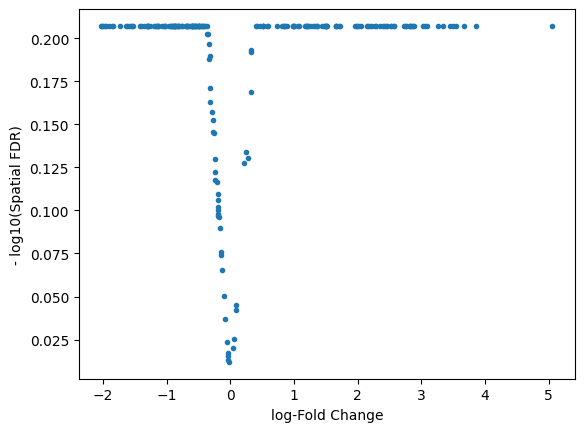

In [57]:
plt.plot(DA_results_myeloid.logFC, -np.log10(DA_results_myeloid.SpatialFDR), '.');
plt.xlabel("log-Fold Change");
plt.ylabel("- log10(Spatial FDR)")

In [58]:
%%R -w 600 -h 450 -i plot_path
library(ggplot2)
alpha_val = 1
for (j in c('SpatialFDR', 'FDR', 'PValue', 'logFC')){
    p1 <- plotNhoodGraphDA(myeloid_milo, DA_results_myeloid, res_column = j, alpha=alpha_val, layout="TSNE", 
                           size_range = c(2, 8), node_stroke =.8)
    ggsave(paste0(plot_path, 'milor_R_myeloid_', j, '.pdf'), p1, dpi = 200)
}

Saving 8.33 x 6.25 in image
Saving 8.33 x 6.25 in image
Saving 8.33 x 6.25 in image
Saving 8.33 x 6.25 in image


In [59]:
%%R -o DA_results_myeloid
DA_results_myeloid <- annotateNhoods(myeloid_milo, DA_results_myeloid, coldata_col = "Celltype_myeloid")
DA_results_myeloid$Myeloid_Celltypes <- ifelse(DA_results_myeloid$Celltype_myeloid_fraction < 0.8, "Mixed", DA_results_myeloid$Celltype_myeloid)
head(DA_results_myeloid)

        logFC   logCPM            F       PValue        FDR Nhood SpatialFDR
1  0.84728381 18.63475  0.712784052 0.3986295178 0.62016943     1  0.6204898
2  3.45557717 13.73214 12.203367560 0.0004881725 0.02038164     2  0.6204898
3 -0.03519113 13.53759  0.002401205 0.9609228826 0.97279364     3  0.9609234
4 -0.49129343 13.53445  0.493613128 0.4824077571 0.68396168     4  0.6204898
5 -0.18811370 13.48799  0.064076008 0.8001938366 0.86370116     5  0.8001968
6 -0.92527409 13.49709  1.611566524 0.2044302930 0.40707231     6  0.6204898
     Celltype_myeloid Celltype_myeloid_fraction   Myeloid_Celltypes
1            Monocyte                 0.3286482               Mixed
2 Alveolar Macrophage                 1.0000000 Alveolar Macrophage
3 Alveolar Macrophage                 1.0000000 Alveolar Macrophage
4     C1QA Macrophage                 1.0000000     C1QA Macrophage
5     C1QA Macrophage                 1.0000000     C1QA Macrophage
6 Alveolar Macrophage                 1.0000000 Alveo

/tmp/ipykernel_835249/208525475.py:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
/tmp/ipykernel_835249/208525475.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
/tmp/ipykernel_835249/208525475.py:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
/tmp/ipykernel_835249/208525475.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
/tmp/ipykernel_835249/208525475.py:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), bu

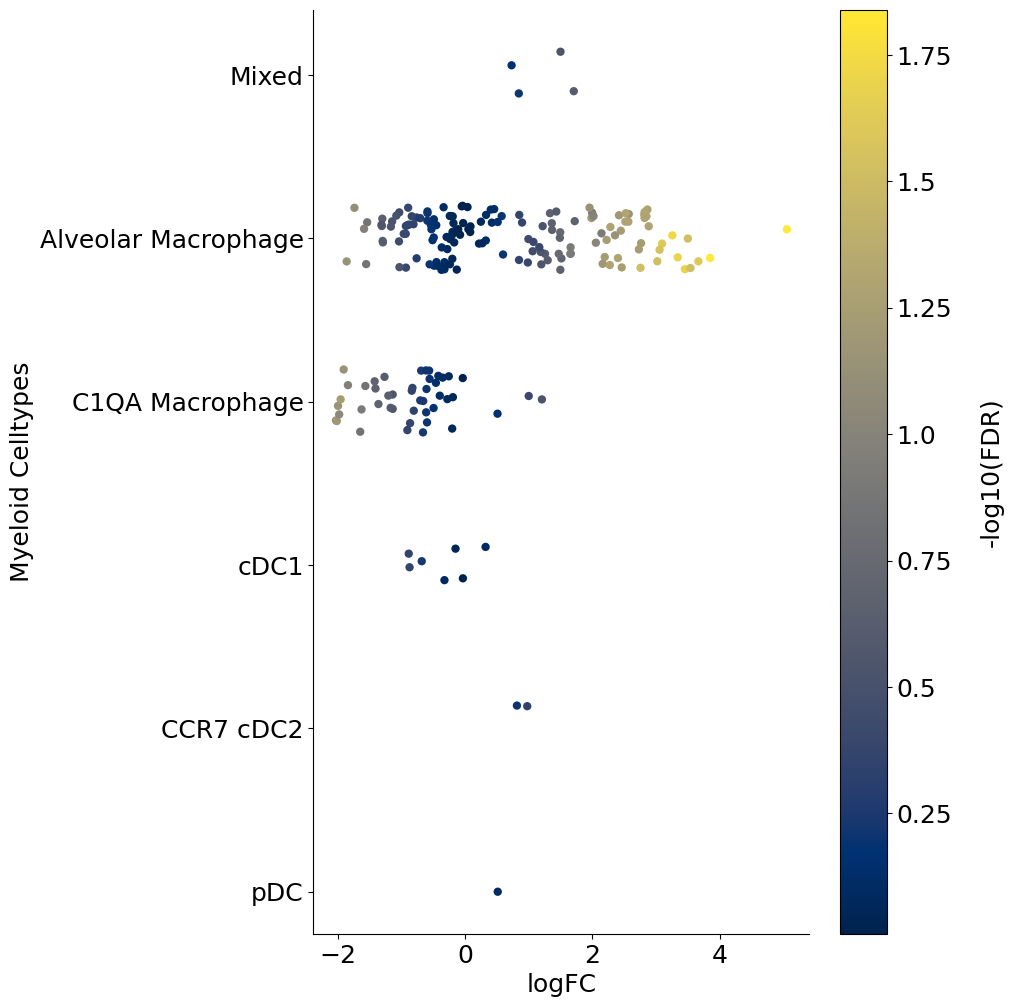

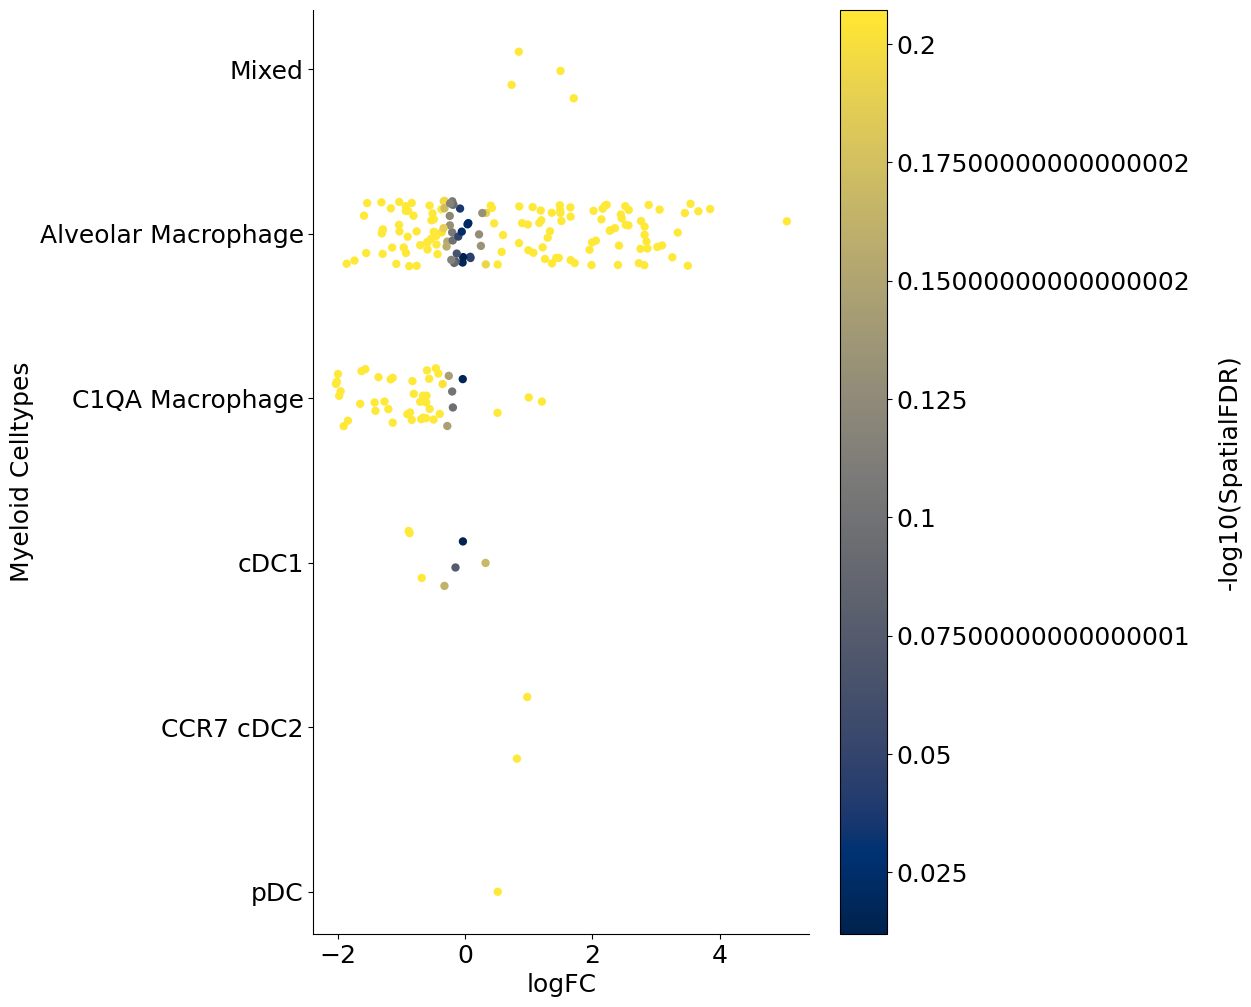

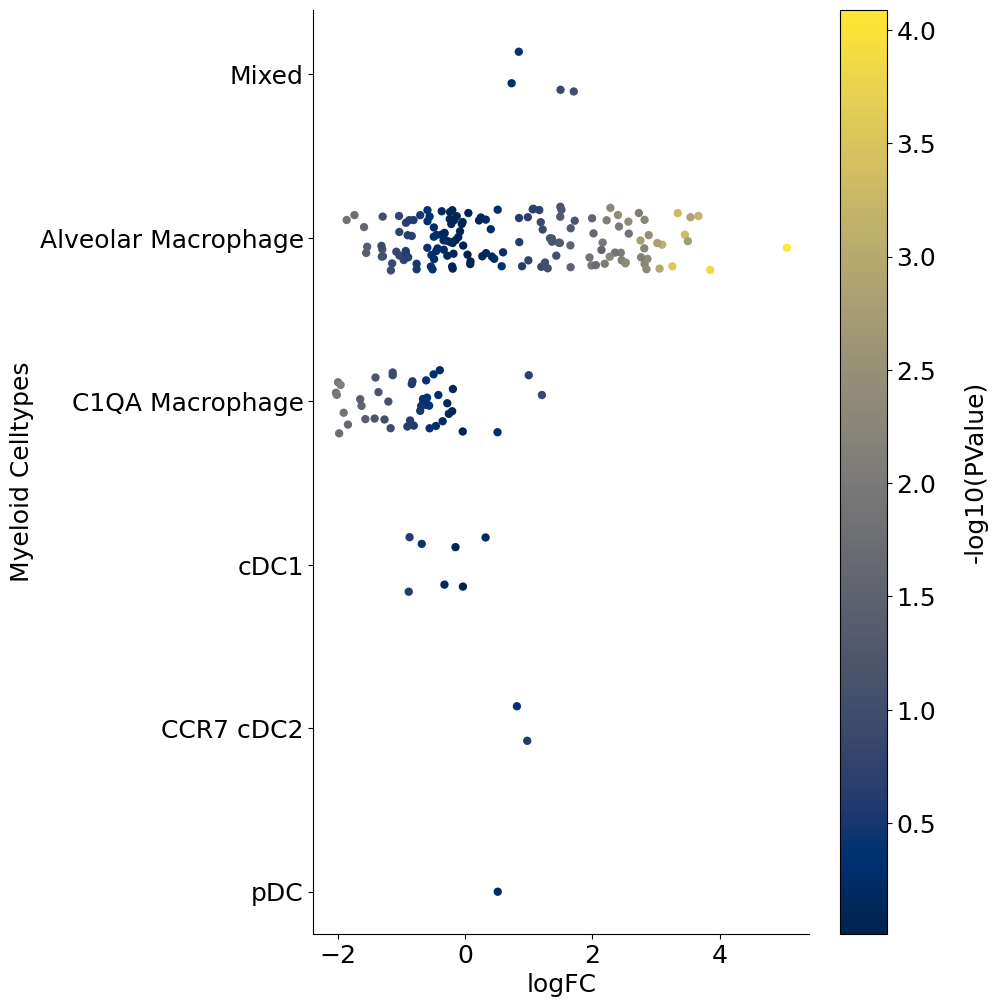

In [60]:
for j, item in enumerate(['FDR', 'SpatialFDR', 'PValue']):
    fig = plt.figure(figsize = (8, 12))
    DA_results_myeloid['log_' + item] = -np.log10(DA_results_myeloid[item])
    ax = fig.add_subplot(1, 1, 1)
    plot = sns.stripplot(x='logFC', y='Myeloid_Celltypes', hue='log_' + item, data=DA_results_myeloid, size = 6, 
              palette='cividis', 
              jitter=0.2, edgecolor='none', ax = ax)
    plot.get_legend().set_visible(False)
    #ax.set_xticklabels(ax.get_xticks(), fontsize = 18)
    #ax.set_yticklabels(ax.get_yticks(), fontsize = 18)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_ylabel('Myeloid Celltypes', fontsize = 18)
    ax.set_xlabel('logFC', fontsize = 18)
    sns.despine()


    # Drawing the side color bar
    normalize = mcolors.Normalize(vmin=DA_results_myeloid['log_' + item].min(), 
                              vmax=DA_results_myeloid['log_' + item].max())
    colormap = cm.cividis

    for n in DA_results_myeloid['log_' + item]:
        plt.plot(color=colormap(normalize(n)))

    scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
    scalarmappaple.set_array(DA_results_myeloid['log_' + item])
    cbar = fig.colorbar(scalarmappaple)
    cbar.ax.set_yticklabels(cbar.ax.get_yticks(), fontsize = 18)
    cbar.ax.set_ylabel('-log10(' + item + ')',  labelpad = 20, rotation=90, fontsize = 18)
    ax.grid(False)
    fig.savefig(plot_path + 'milor_myeloid_swarmplot_colored_by_log_' + item + '.pdf', dpi = 300, 
                bbox_inches = 'tight')